
This notebook serves as a tutorial for microglia composition analysis with scCODA


In [ ]:
pip install sccoda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.1 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82813 sha256=1b76b0b71a8a229b04b9c67b06086a562cff97771e5ac92221e17e695e608b3e
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=3129aff2a6a202d9bd70c1c53a20658242eda6d3dc8352681d44163058462077
  Stored in directory: /root/.cache/pip/wheels/6a/aa

In [ ]:
# Setup
import importlib
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

import sccoda.datasets as scd

### Data preparation

In [ ]:
??scd.haber

In [ ]:
# Load data

cell_counts = pd.read_csv("/content/sccoda.csv") #scd.haber("/content/sample_data/No_of_nuclei_0.25res_sccoda.csv")

print(cell_counts)

  Mouse  Hemo1  IRMs1  IRMs2  DAM1  DAM1.1  DAM1.2  DAM2  DAM3  DAM4
0   L01   2014    194    111  1607     144     253   112   224   101
1   L02   1462    302    187   866      68     125    74   115   547
2   L03   1371    112     59  1508     147     300   137   259   137
3   L04   1870    182    131  1468     153     258   135   139    51
4   L05   1975    159    110  1518     152     281   154   189   169
5   L06   1825    246    122  1777     160     339   165   116    45


Looking at the data, we see that we have 4 control samples, and 3 conditions with 2 samples each.
To use the models in *scCODA*, we first have to convert the data into an [anndata](https://github.com/theislab/anndata) object.
This can be done easily with the `sccoda.util.cell_composition_data` module.
The resulting object separates our data components: Cell counts are stored in `data.X`, covariates in `data.obs`.

In [ ]:
#data_all = dat.from_pandas(cell_counts, covariate_columns=["Mouse"])

# Extract condition from mouse name and add it as an extra column to the covariates
#data_all.obs["Condition"] = data_all.obs["Mouse"].str.replace(r"_[0-9]", "", regex=True)
#print(data_all.obs)

print(cell_counts.columns)

import pandas as pd
import anndata as ad

# Assuming cell_counts is the DataFrame containing your data
# Remove leading or trailing whitespace from column names
cell_counts.columns = cell_counts.columns.str.strip()

# Convert data to anndata object
data_all = ad.AnnData(X=cell_counts.iloc[:, 1:].values,  # Exclude the 'Mouse' column
                      obs=cell_counts.set_index('Mouse'),  # Use 'Mouse' as observation (obs) index
                      var={'Cluster': cell_counts.columns[1:]})  # Set 'Cluster_X' as the feature (var) metadata

# Extract condition from mouse name and add it as an extra column to the obs metadata
data_all.obs["Condition"] = data_all.obs_names.str.replace(r"_[0-9]", "", regex=True)

print(data_all)



Index(['Mouse', 'Hemo1', 'IRMs1', 'IRMs2', 'DAM1', 'DAM1.1', 'DAM1.2', 'DAM2',
       'DAM3', 'DAM4'],
      dtype='object')
AnnData object with n_obs × n_vars = 6 × 9
    obs: 'Hemo1', 'IRMs1', 'IRMs2', 'DAM1', 'DAM1.1', 'DAM1.2', 'DAM2', 'DAM3', 'DAM4', 'Condition'
    var: 'Cluster'


For our first example, we want to look at how the Salmonella infection influences the cell composition.
Therefore, we subset our data.

In [ ]:

# Select control and salmonella data
data_salm = data_all
data_salm.obs["Condition"] = ["Control","Control","Control","T_depletion","T_depletion","T_depletion"]
print(data_salm.obs)

#data_salm = data_all[data_all.obs["Condition"].isin(["Young", "Aged"])]
#print(data_salm.obs)


       Hemo1  IRMs1  IRMs2  DAM1  DAM1.1  DAM1.2  DAM2  DAM3  DAM4  \
Mouse                                                                
L01     2014    194    111  1607     144     253   112   224   101   
L02     1462    302    187   866      68     125    74   115   547   
L03     1371    112     59  1508     147     300   137   259   137   
L04     1870    182    131  1468     153     258   135   139    51   
L05     1975    159    110  1518     152     281   154   189   169   
L06     1825    246    122  1777     160     339   165   116    45   

         Condition  
Mouse               
L01        Control  
L02        Control  
L03        Control  
L04    T_depletion  
L05    T_depletion  
L06    T_depletion  


Plotting the data, we can see that there is a large increase of Enterocytes in the infected sampes, while most other cell types slightly decrease.
Since scRNA-seq experiments are limited in the number of cells per sample, the count data is compositional, which leads to negative correlations between the cell types.
Thus, the slight decreases in many cell types might be fully caused by the increase in Enterocytes.

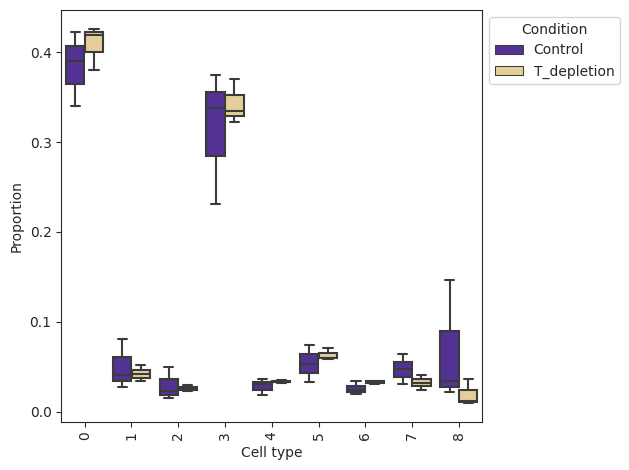

In [ ]:
boxplot = viz.boxplots(data_salm, feature_name="Condition",cmap = ["#4f22a3","#f2d38c"])
plt.show()
#plt.savefig('/boxplot.pdf', format='pdf')

#from google.colab import files
#files.download('boxplot.pdf')


*Note that the use of* anndata *in* scCODA *is different from the use in scRNA-seq pipelines, e.g.* scanpy.
*To convert* scanpy *objects to a scCODA dataset, have a look at `dat.from_scanpy.*

### Model setup and inference

We can now create the model and run inference on it. Creating a `sccoda.util.comp_ana.CompositionalAnalysis` class object
sets up the compositional model and prepares everxthing for parameter inference. It needs these informations:

- The data object from above.

- The `formula` parameter. It specifies how the covariates are used in the model.
It can process R-style formulas via the [patsy](https://patsy.readthedocs.io/en/latest/) package, e.g. `formula="Cov1 + Cov2 + Cov3"`.
Here, we simply use the "Condition" covariate of our dataset

- The `reference_cell_type` parameter is used to specify a cell type that is believed to be unchanged by the covariates in `formula`.
This is necessary, because compositional analysis must always be performed relative to a reference (See [Büttner, Ostner et al., 2021](https://www.nature.com/articles/s41467-021-27150-6) for a more thorough explanation).
If no knowledge about such a cell type exists prior to the analysis, taking a cell type that has a nearly constant relative abundance over all samples is often a good choice.
It is also possible to let scCODA find a suited reference cell type by using `reference_cell_type="automatic"`.
Here, we take Goblet cells as the reference.

In [ ]:
model_salm = mod.CompositionalAnalysis(data_salm, formula="Condition", reference_cell_type=0)

HMC sampling is then initiated by calling `model.sample_hmc()`, which produces a `sccoda.util.result_classes.CAResult` object.

In [ ]:
# Run MCMC
sim_results = model_salm.sample_hmc()

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
100%|██████████| 20000/20000 [01:28<00:00, 226.07it/s]


MCMC sampling finished. (111.400 sec)
Acceptance rate: 59.5%


### Result interpretation

Calling `summary()` on the results object, we can see the most relevant information for further analysis:

In [ ]:
sim_results.summary()

Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
           Final Parameter  Expected Sample
Cell Type                                  
0                    2.509       446.273837
1                    1.727       204.165869
2                    3.954      1893.027630
3                    1.937       251.874953
4                    1.404       147.810751
5                    1.101       109.172887
6                    3.527      1235.131532
7                    1.831       226.542541


Effects:
                                    Final Parameter  Expected Sample  \
Covariate                Cell Type                                     
Condition[T.T_depletion] 0                      0.0       446.273837   
                         1                      0.0       204.165869   
                         2                      0.0      1893.027630   
                         3                      0.0       251.874953   
   

**Model properties**

First, the summary shows an overview over the model properties:
* Number of samples/cell types
* The reference cell type.
* The formula used

The model has two types of parameters that are relevant for analysis - intercepts and effects.
These can be interpreted like in a standard regression model:
Intercepts show how the cell types are distributed without any active covariates, effects show ho the covariates influence the cell types.

**Intercepts**

The first column of the intercept summary shows the parameters determined by the MCMC inference.

The "Expected sample" column gives some context to the numerical values.
If we had a new sample (with no active covariates) with a total number of cells equal to the mean sampling depth of the dataset,
then this distribution over the cell types would be most likely.

**Effects**

For the effect summary, the first column again shows the inferred parameters for all combinations of covariates and cell types.
Most important is the distinctions between zero and non-zero entries
A value of zero means that no statistically credible effect was detected.
For a value other than zero, a credible change was detected. A positive sign indicates an increase, a negative sign a decrease in abundance.

Since the numerical values of the "Final Parameter" column are not straightforward to interpret, the "Expected sample" and "log2-fold change" columns give us an idea on the magnitude of the change.
The expected sample is calculated for each covariate separately (covariate value = 1, all other covariates = 0), with the same method as for the intercepts.
The log-fold change is then calculated between this expected sample and the expected sample with no active covariates from the intercept section.
Since the data is compositional, cell types for which no credible change was detected, can still change in abundance as well, as soon as a credible effect is detected on another cell type due to the sum-to-one constraint.
If there are no credible effects for a covariate, its expected sample will be identical to the intercept sample, therefore the log2-fold change is 0.

**Interpretation**

In the salmonella case, we see only a credible increase of Enterocytes, while all other cell types are unaffected by the disease.
The log-fold change of Enterocytes between control and infected samples with the same total cell count lies at about 1.54.

We can also easily filter out all credible effects:

### Adjusting the False discovery rate

scCODA selects credible effects based on their inclusion probability.
The cutoff between credible and non-credible effects depends on the desired false discovery rate (FDR).
A smaller FDR value will produce more conservative results, but might miss some effects,
while a larger FDR value selects more effects at the cost of a larger number of false discoveries.

The desired FDR level can be easily set after inference via `sim_results.set_fdr()`. Per default, the value is 0.05,
but we recommend to increase it if no effects are found at a more conservative level.

In our example, setting a desired FDR of 0.4 reveals effects on Endocrine and Enterocyte cells.

In [ ]:
sim_results.set_fdr(est_fdr=0.4)
sim_results.summary()
print(sim_results.credible_effects())

Compositional Analysis summary:

Data: 6 samples, 9 cell types
Reference index: 0
Formula: Condition

Intercepts:
           Final Parameter  Expected Sample
Cell Type                                  
0                    3.786      1762.264441
1                    1.633       204.660984
2                    1.165       128.169663
3                    3.575      1427.036044
4                    1.281       143.934002
5                    1.862       257.328859
6                    1.230       136.777412
7                    1.529       184.445657
8                    1.384       159.549605


Effects:
                                    Final Parameter  Expected Sample  \
Covariate                Cell Type                                     
Condition[T.T_depletion] 0                 0.000000      1792.618933   
                         1                 0.000000       208.186210   
                         2                 0.000000       130.377348   
                         3     